## Do it! Natural Language Processing using BERT and GPT - part6
#### 한국어 자연어 처리에 관한 내용을 정리하였습니다. Do it! BERT와 GPT로 배우는 자연어 처리(이기창 지음)을 참고하였습니다.
## 6. 단어에 꼬리표 달기
### 6.1 개체명 인식 모델 훑어보기

#### 개체명인식(NER) : 문장을 토큰화한 뒤 토큰 각각에 개체명 태그를 붙여주는 과제

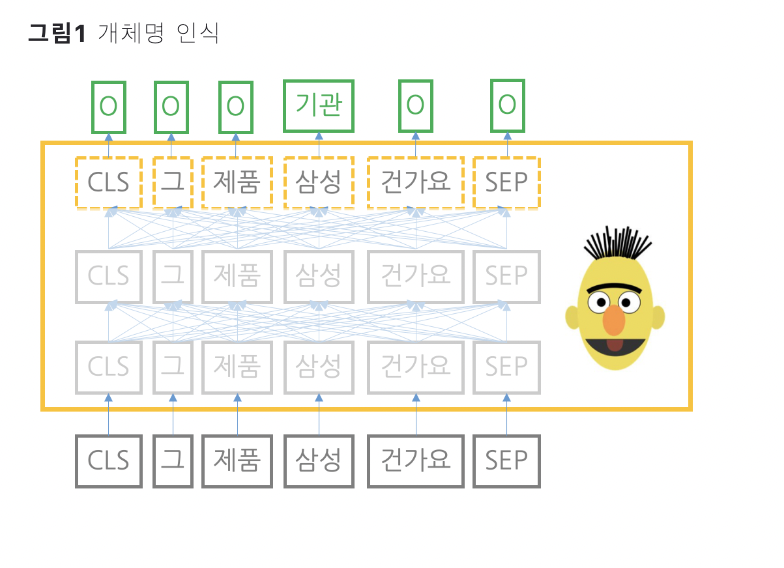
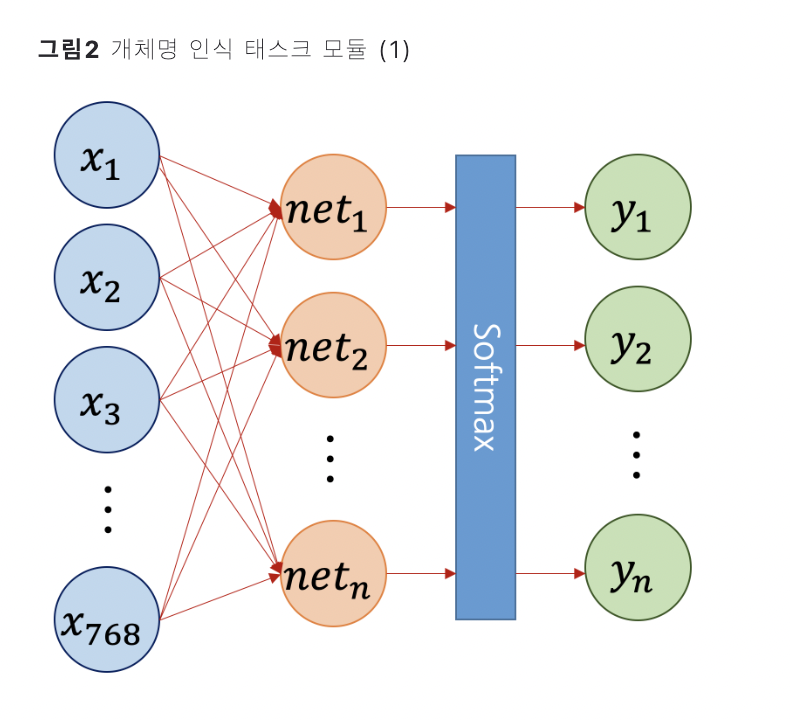
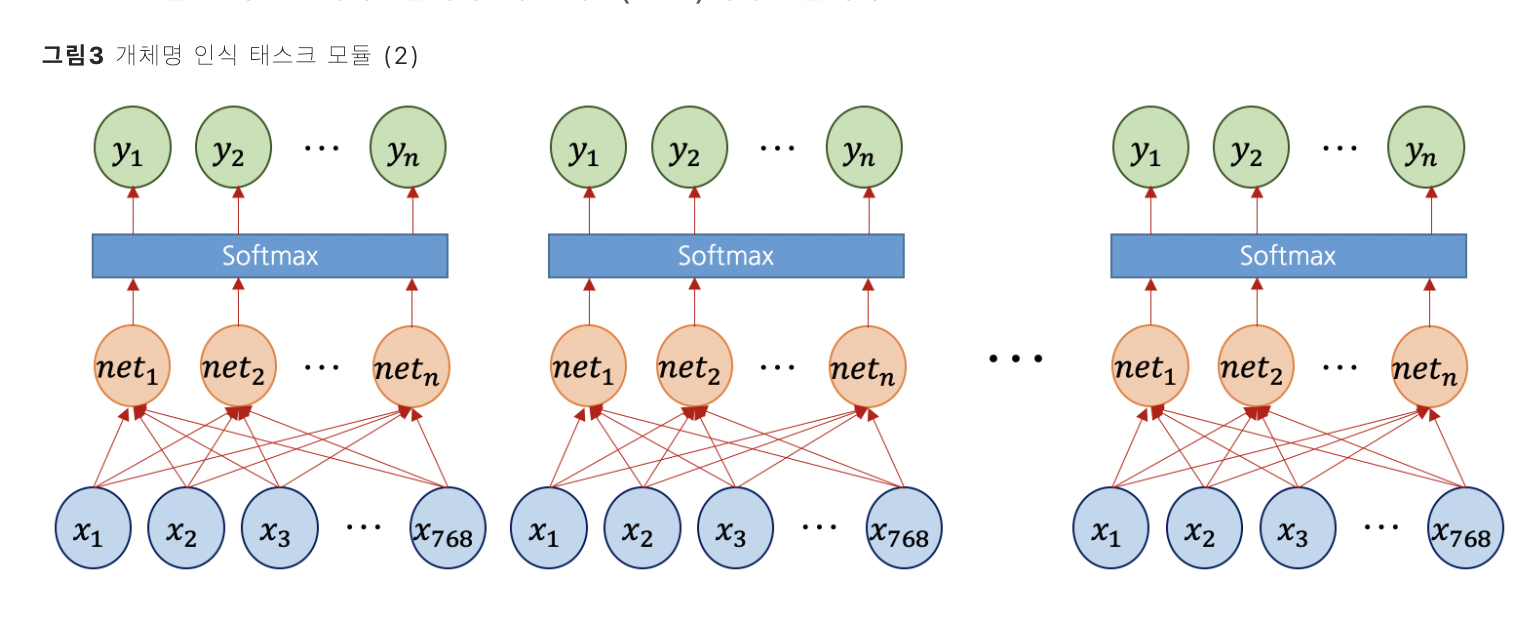

### 6.2 개체명 인식 모델 학습하기

In [ ]:
#### 모델 환경 설정
import torch 
from ratsnlp.nlpbook.ner import NERTrainArguments
args = NERTrainArguments(pretrained_model_name='beomi/kcbert-base',
                        downstream_corpus_name='ner',
                        downstream_model_dir='./part4-model',
                        batch_size=32 if torch.cuda.is_available() else 4,
                        learning_rate=5e-5,
                        max_seq_length = 64,
                        epochs=3, 
                        tpu_cores=0 if torch.coda.is_available() else 8,
                        seed=7)

#### 랜덤시드 고정
from ratsnlp import nlpbook
nlpbook.set_seed(args)

#### 로거 설정
nlpbook.set_logger(args)

#### 말뭉치 다운로드
nlpbook.download_downstream_dataset(args)

#### 토크나이저 준비
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(args.pretrained_model_name,
                                         do_lower_case = False)

#### 학습 데이터셋 구축
from ratsnlp.nlpbook.ner import NERCorpus, NERDataset
corpus = NERCorpus(args)
train_dataset = NERDataset(args = args,
                          corpus = corpus,
                          tokenizer = tokenizer,
                          mode = 'train')
#### 학습 데이터로더 구축
from torch.utils.data import DataLoader, RandomSampler
train_dataloader = DataLoader(train_dataset, 
                             batch_size = args.batch_size,
                             samplier = RandomSampler(train_datset, replacement=False),
                             collate_fn=nlpbook.data_collator,
                             drop_last = False,
                             num_workers=args.cpu_workers)

#### 평가용 데이터로더 구축
from torch.utils.data import SequentialSampler
val_dataset = NERDataset(args=args, corpus=corpus, tokenizer=tokenizer, model='val')
val_dataloader = DataLoader(val_dataset, batch_size = args.batch_size, sampler=SequentialSampler(val_dataset),
                           collate_fn=nlpbook.data_collator, drop_last=False, num_workers=args.cpu_workers)

#### 모델 초기화
from transformers import BertConfig, BertForTokenClassification
pretrained_model_config = BertConfig.from_pretrained(args.pretrained_model_name, num_labels=corpus.num_labels)
model = BertForTokenClassification.from_pretrained(args.pretrained_model_name, config = pretrained_model_config)

#### 태스크 정의
from ratsnlp.nlpbook.ner import NERTask
task = NERTask(model, args)

#### 트레이너 정의
trainer = nlpbook.get_trainer(args)

#### 학습 개시
trainer.fit(task, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

### 6.3 학습 마침 모델을 실전 투입하기

In [ ]:
#### 인퍼런스 설정
from ratsnlp.nlpbook.ner import NERDeployArguments
args = NERDeployArguments(pretrained_model_name = 'beomi/kcbert-base',
                         downstream_model_dir = './part4-model',
                         max_seq_length = 64)

#### 토크나이저 로드
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(args.pretrained_model_name, do_lower_case = False)

#### 체크포인트 로드
import torch 
fine_tuned_model_ckpt = torch.load(args.downstream_model_checkpoint_fpath, map_location=torch.device('cpu'))

#### BERT 설정 로드
from transformers import BertConfig
pretrained_model_config = BertConfig.from_pretrained(args.pretrained_model_name, 
                                                    num_labels=fine_tuned_model_ckpt['state_dict']['model.classifier.bias'].shape.numel())

#### BERT 모델 초기화
from transformers import BertForTokenClassification
model = BertForTokenClassification(pretrained_model_config)

#### 체크포인트 주입하기
model.load_state_dict({k.replace("model.", "") : v for k, v in fine_tuned_model_ckpt['state_dict'].items()})

#### 평가모드로 전환
model.eval()

#### 레이블 맵 작성
labels = [label.strip() for label in open(args.downstream_model_labelmap_fpath, 'r').readlines()]
id_to_label = {}
for idx, label in enumerate(labels):
    if "PER" in label:
        label = '인명'
    elif "LOC" in label:
        label = '지명'
    elif "ORG" in label:
        label = '기관명'
    elif "DAT" in label:
        label = '날짜'
    elif "TIM" in label:
        label = '시간'
    elif "DUR" in label:
        label = '기간'
    elif "MNY" in label:
        label = '통화'
    elif "PNT" in label:
        label = '비율'
    elif "NOH" in label:
        label = '기타 수량표현'
    elif "POH" in label:
        label = '기타'
    else:
        label = label
    
    id_to_label[idx] = label
    

#### 인퍼런스
def inference_fn(sentence):
    inputs = tokenizer([sentence], max_length=args.max_seq_length, padding = 'max_length', truncation=True)
    
    with torch.no_grad():
        outputs = model(**{k: torch.tensor(v) for k, v in inputs.items()})
        probs = outputs.logits[0].softmax(dim=1)
        top_probs, preds = torch.topk(probs, dim=1, k=1)
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        predicted_tags = [id_to_label[pred.items()] for pred in preds]
        result = []
        for token, predicted_tag, top_prob in zip(tokens, predicted_tags, top_probs):
            if token not in [tokenizer.pad_token, tokenizer.cls_token, tokenizer.sep_token]:
                token_result = {
                    'token' : token,
                    'predicted_tag' : predicted_tag,
                    'top_prob' : str(round(top_prob[0].item(), 4))
                }
                result.append(token_result)
                
    return {
        "sentence" : sentence,
        "result" : result
    }